Project image sequence colorization 

LACHOUQUE Jacque 
KOÏTA Adama


In [39]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [40]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import sys
import os

In [42]:
%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [43]:
def imshow_plt(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional

    
def imshow_cv(image, cmap=None):
  plt.imshow(image, cmap)
  plt.show()

(557, 362, 3)


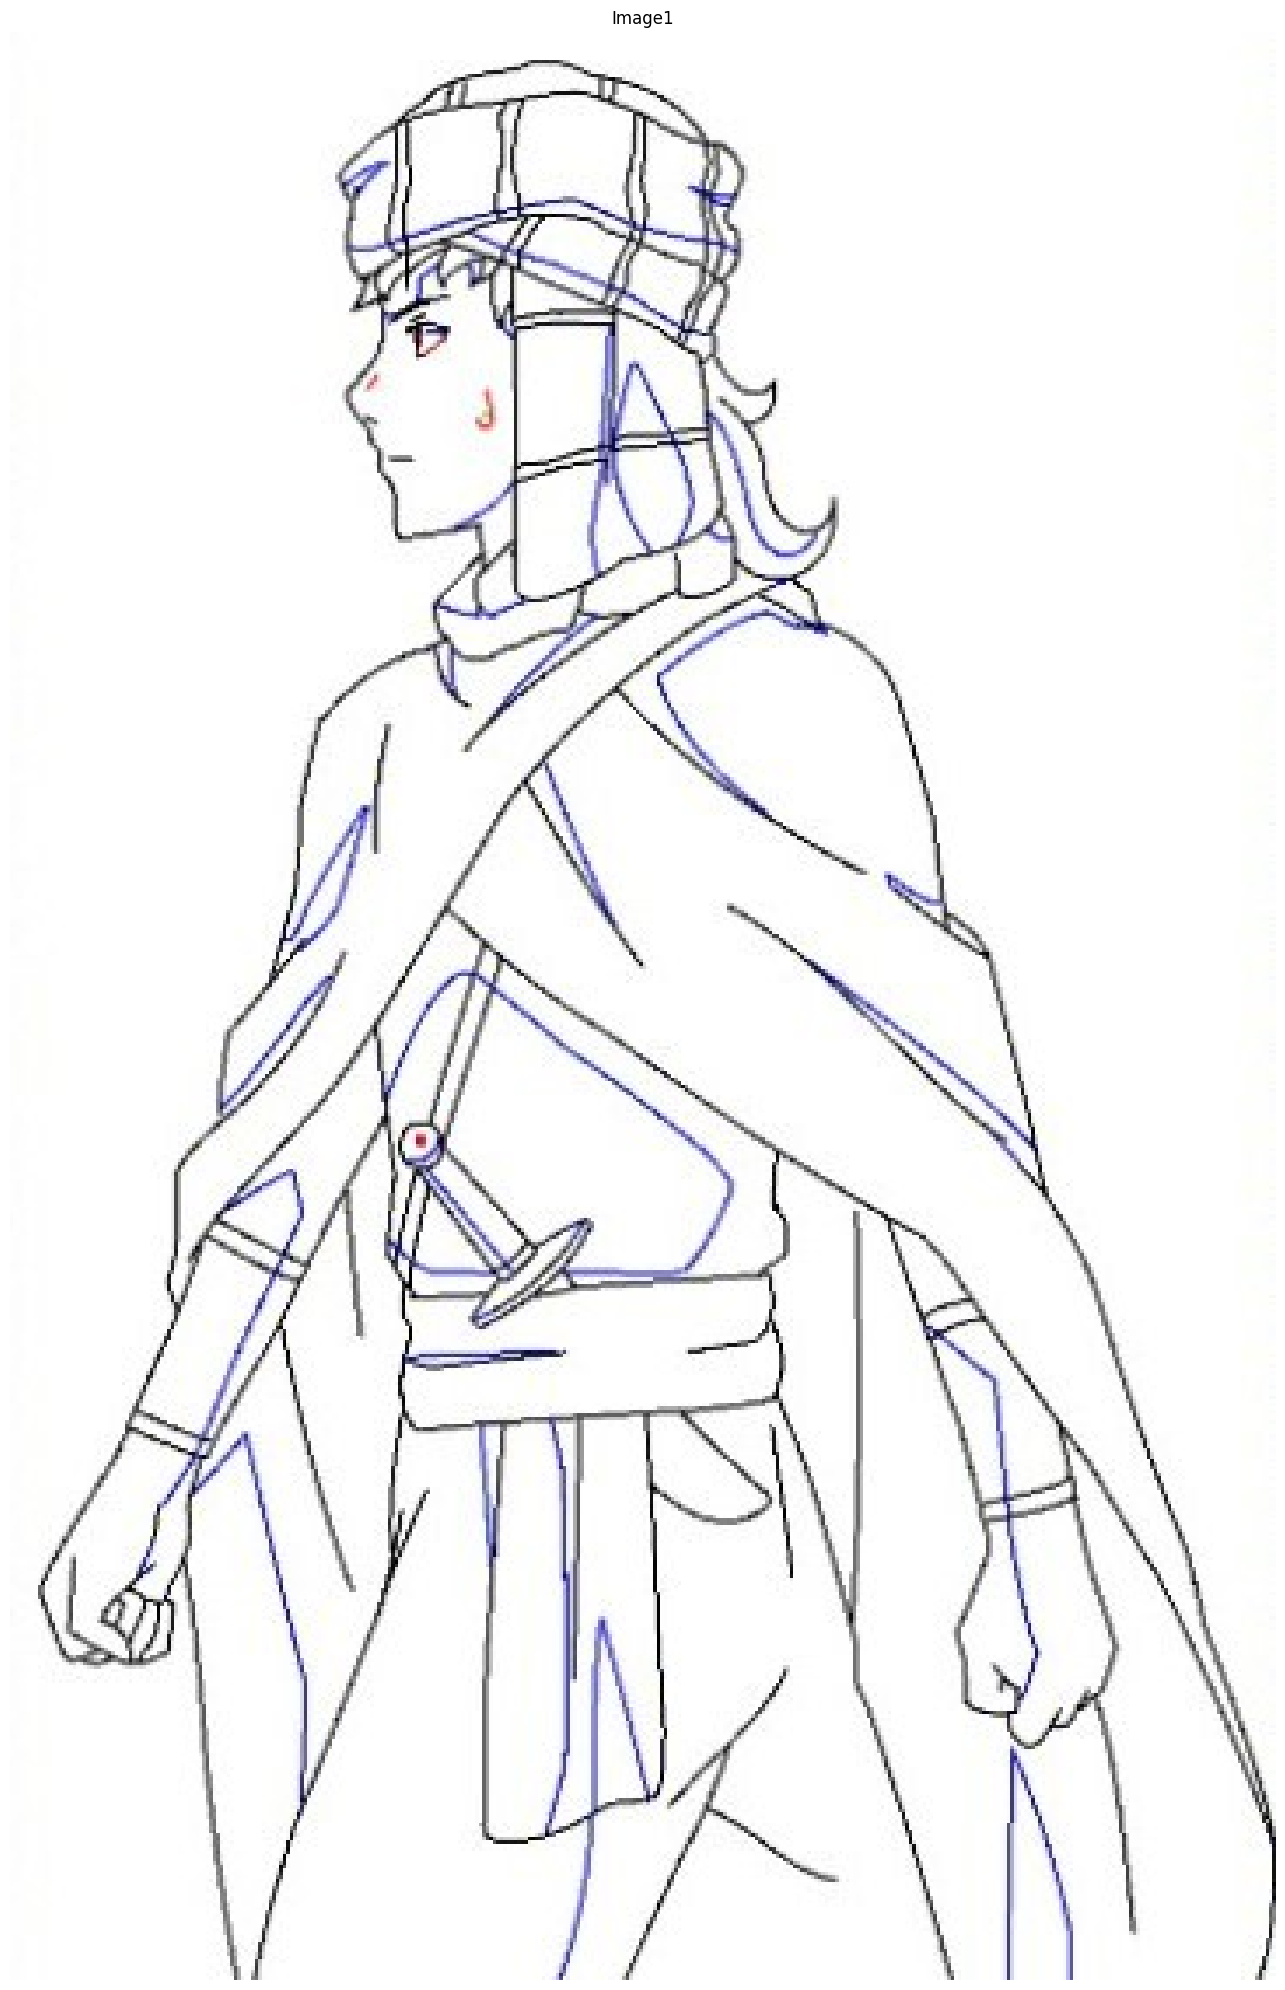

In [44]:
# Read an image as a PyTorch tensor
myimage = io.imread("dataset/sketch/1.jpg")
imshow_plt( [myimage], ['Image1'])
print(myimage.shape)

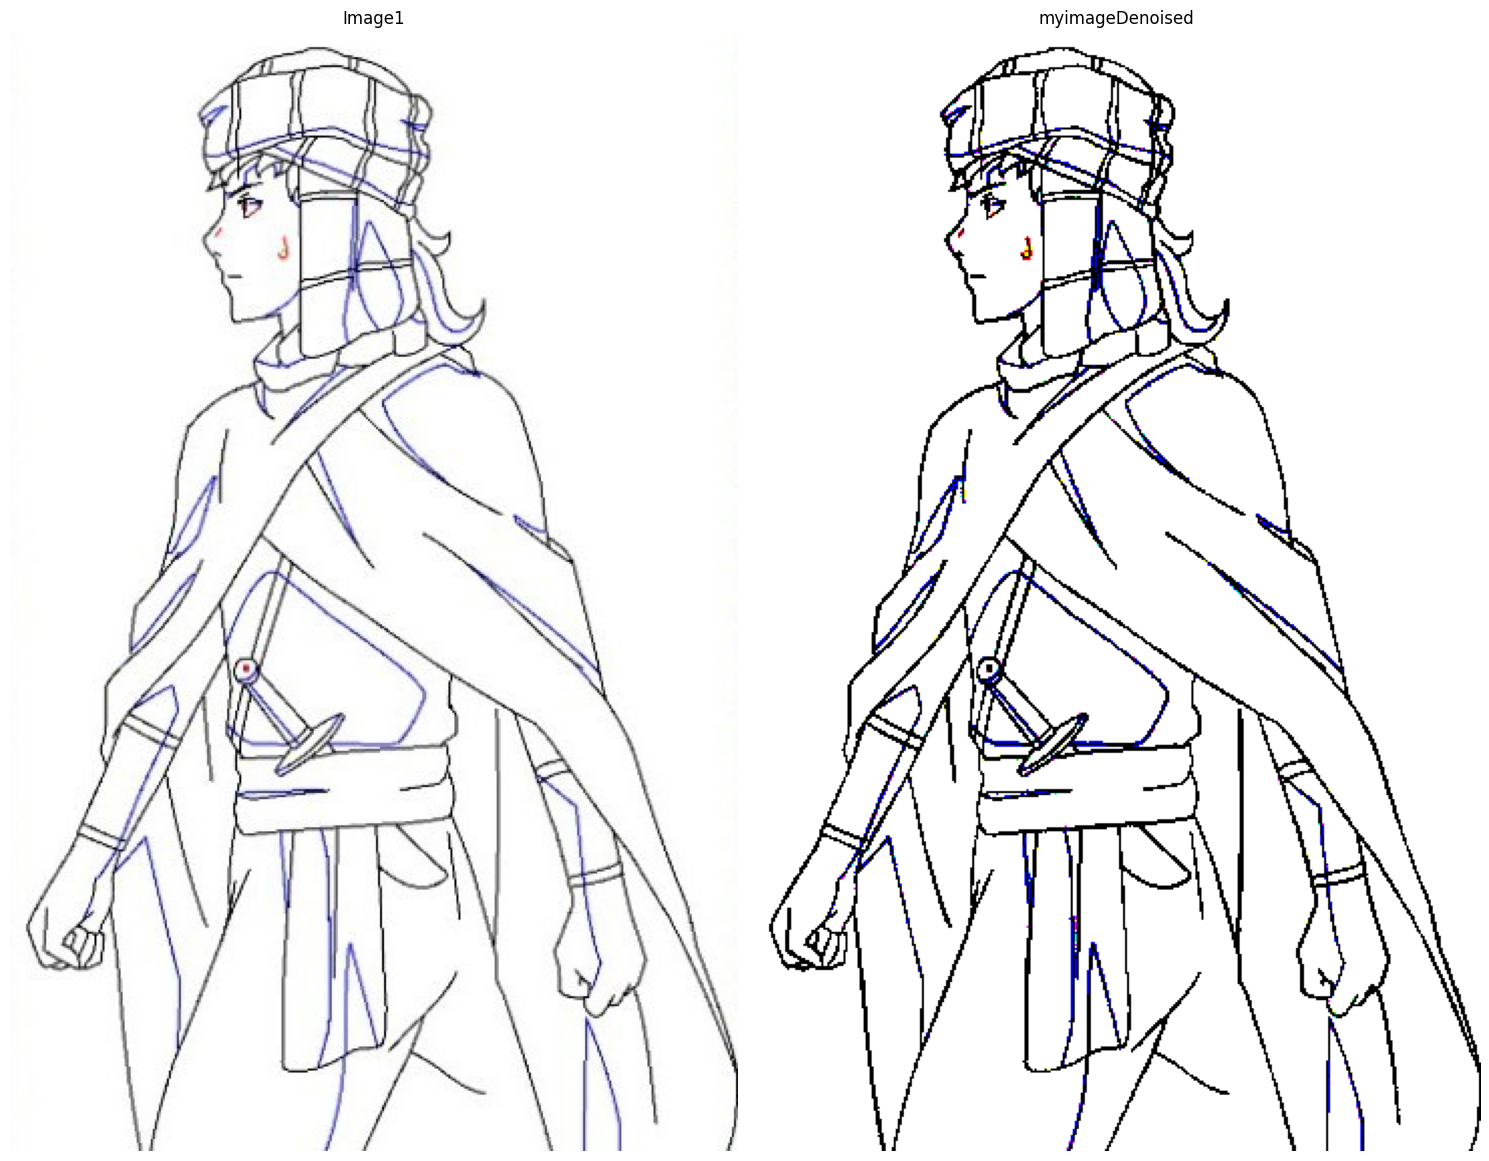

In [45]:


def threshold(img, value):
   return np.where(img <= value, 0, 255)


myimage_denoised = threshold(myimage,200)

imshow_plt( [myimage, myimage_denoised], ['Image1', 'myimageDenoised'])


Here are some test 

(557, 362)


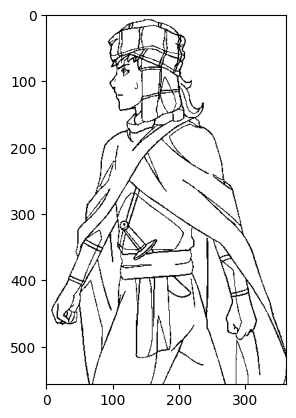

In [46]:
treatedPixMat = np.zeros((myimage.shape[0], myimage.shape[1]))
treatedPixMat =  np.where(
    (myimage_denoised[..., 0] == 255) & 
    (myimage_denoised[..., 1] == 255) & 
    (myimage_denoised[..., 2] == 255),
    
    treatedPixMat, -1
)
treatedPixMat =  np.where(
    (myimage_denoised[..., 0] != 255) & 
    (myimage_denoised[..., 1] != 255) & 
    (myimage_denoised[..., 2] != 255),
    
    treatedPixMat, 0
)
print(treatedPixMat.shape)
imshow_cv(treatedPixMat)

In [47]:
list_index_zeros = list(zip(*np.where(treatedPixMat == 0))) # * separe les deux array produit par np.where en deux array distinc et zip combine les élement pour les transformé en tuple
print(np.array(list_index_zeros).shape)
print(list_index_zeros[2])


(186526, 2)
(np.int64(0), np.int64(2))


In [48]:
print(treatedPixMat[0,50])

0.0


Some function to colorize an image

In [49]:
from random import randint

def apply_class_in_matrix_browsing_lines(classes_matrix,treated_pixels, class_num):

    new_treated_pixels = treated_pixels.copy()
    for line in range(classes_matrix.shape[0]):
        for col in range(classes_matrix.shape[1]):#parcourir de la gauche 
           
            if(classes_matrix[line][col] == -1):
                    if(col !=0):
                        if(treated_pixels[line][col-1]):#and classes_matrix[line][col+1] ==0
                            continue
                        else:
                            break

                    
            if(classes_matrix[line][col] == 0):
                classes_matrix[line][col] = class_num
                new_treated_pixels[line][col] = True



        for col in range(classes_matrix.shape[1]-1,0,-1): #parcourir de la droite 
            if(classes_matrix[line][col] == -1 ):
                if(classes_matrix[line][col] == -1):
                    if(col !=classes_matrix.shape[1]-1):
                        if(treated_pixels[line][col+1]):#and classes_matrix[line][col+1] ==0
                            continue
                        else:
                            break
            if(classes_matrix[line][col] == 0):
                classes_matrix[line][col] = class_num
                new_treated_pixels[line][col] = True
                
    return  classes_matrix, new_treated_pixels




def classes_matrix_to_image(classes_matrix, list_class):
    image = np.zeros((classes_matrix.shape[0],classes_matrix.shape[1],3), dtype=int)
    for c in list_class:
        mask = (classes_matrix == c)
        random_color = (randint(0, 255), randint(0, 255), randint(0, 255))
        image[mask] = random_color
        #print("class "+ str(c)+" color:",random_color)
    return image

def assign_class_to_pixel_browse_by_lines(image):

    #create matrix of classes
    classes_matrix = np.zeros((image.shape[0], image.shape[1]))
    classes_matrix =  np.where(
    (image[..., 0] == 255) & 
    (image[..., 1] == 255) & 
    (image[..., 2] == 255),
    classes_matrix, -1)
    

    print(classes_matrix.shape)
    
    last_class = 1
    classes_num_list = [1]
    show_steps = np.array([0,1,250])

    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)
    mask = (classes_matrix == -1)
    treated_pixels[mask] = True        
    #print(treated_pixels)

    while(np.isin(classes_matrix,0).any()):
        classes_matrix, new_treated_pixels = apply_class_in_matrix_browsing_lines(classes_matrix, treated_pixels,last_class)
        treated_pixels = new_treated_pixels.copy()
        #print("shape classes_matrix",classes_matrix.shape)
        #print("step",last_class-1)
        #imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
        #print(classes_matrix[200])
        #imshow_plt([classes_matrix_to_image(classes_matrix, classes_num_list)],['classe'+str(last_class)])


        last_class+=1
        classes_num_list.append(last_class)


    return classes_matrix, classes_num_list




(557, 362)
(557, 362)
filling with raw image


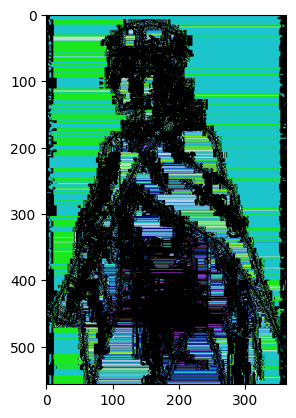

filling with denoised image


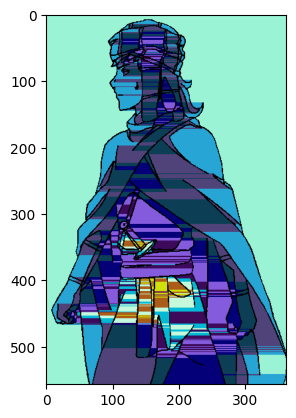

In [ ]:
classes_matrix ,classes_num_list  = assign_class_to_pixel_browse_by_lines(myimage)
classes_matrix_image_denoised, classes_num_list_image_denoised = assign_class_to_pixel_browse_by_lines(myimage_denoised)
print("filling with raw image")
imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
print("filling with denoised image")
imshow_cv(classes_matrix_to_image(classes_matrix_image_denoised, classes_num_list_image_denoised))


In [76]:
def filling(i,j,classes_matrix,treated_pixels, class_num ):
    stack = [(i,j)] #utilisation de stack car probleme avec la recursion

    while stack :
        x,y = stack.pop()
        if(classes_matrix[x][y] == 0):
            classes_matrix[x][y] = class_num
            treated_pixels[x][y] = True
            if(x != 0):
                #classes_matrix = filling(x-1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x - 1, y))
            if(x != classes_matrix.shape[0]-1):
                #classes_matrix =filling(x+1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x + 1, y))
            if(y != 0):
                #classes_matrix =filling(x,y-1,classes_matrix,treated_pixels, class_num)
                stack.append((x, y - 1))
            if(y != classes_matrix.shape[1]-1):
                #classes_matrix =filling(x,y+1,classes_matrix,treated_pixels, class_num)
                stack.append((x , y+ 1))
    return classes_matrix

def assign_class_to_pixel_by_filling(image):
    #create matrix of classes
    classes_matrix = np.zeros((image.shape[0], image.shape[1]))
    classes_matrix =  np.where(
    (image[..., 0] == 255) & 
    (image[..., 1] == 255) & 
    (image[..., 2] == 255),
    classes_matrix, -1)
   
    print(classes_matrix.shape)
    #imshow_cv(classes_matrix)
    
    last_class = 1
    classes_num_list = [1]
    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)
    mask = (classes_matrix == -1)
    treated_pixels[mask] = True        
    while(np.isin(classes_matrix,0).any()):
        #classes_matrix, new_treated_pixels = apply_class_in_matrix(classes_matrix, treated_pixels,last_class)
        #treated_pixels = new_treated_pixels.copy()
        fill = False
        for line in range(classes_matrix.shape[0]):
            for col in range(classes_matrix.shape[1]):#parcourir de la gauche 
                if(classes_matrix[line][col] == 0):
                    filling(line, col,classes_matrix, treated_pixels,last_class)
                    fill =True

                    break
            if(fill): break
                        
                
        #print("step",last_class-1)
        #imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
        #print(classes_matrix[200])
        #imshow_plt([classes_matrix_to_image(classes_matrix, classes_num_list)],['classe'+str(last_class)])
        

        last_class+=1
        classes_num_list.append(last_class)


    return classes_matrix, classes_num_list


(557, 362)
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33
step 34
step 35
step 36
step 37
step 38
step 39
step 40
step 41
step 42
step 43
step 44
step 45
step 46
step 47
step 48
step 49
step 50
step 51
step 52
step 53
step 54
step 55
step 56
step 57
step 58
step 59
step 60
step 61
step 62
step 63
step 64
step 65
step 66
step 67
step 68
step 69
step 70
step 71
step 72
step 73
step 74
step 75
step 76
step 77
step 78
step 79
step 80
step 81
step 82
step 83
step 84
step 85
step 86
step 87
step 88
step 89
step 90
step 91
step 92
step 93
step 94
step 95
step 96
step 97
step 98
step 99
step 100
step 101
step 102
step 103
step 104
step 105
step 106
step 107
step 108
step 109
step 110
step 111
step 112
step 113
step 114
step 115
step 116
step 117
step 118
step 119
step 120
step 121
s

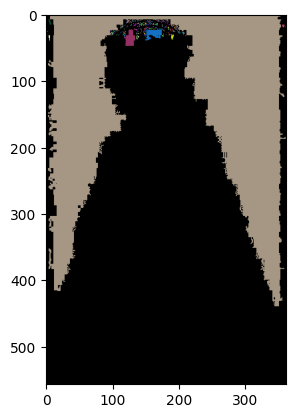

filling with denoised image


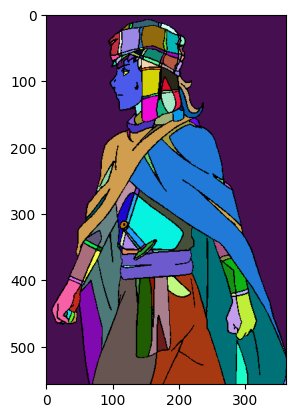

In [52]:
classes_matrix, classes_num_list_image_denoised = assign_class_to_pixel_by_filling(myimage)
classes_matrix_image_denoised, classes_num_list = assign_class_to_pixel_by_filling(myimage_denoised)
print("filling with raw image")
imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
print("filling with denoised image")
imshow_cv(classes_matrix_to_image(classes_matrix_image_denoised, classes_num_list_image_denoised))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [23..510].


(526, 478, 4)
(526, 478)
Apply pixel from previous to new


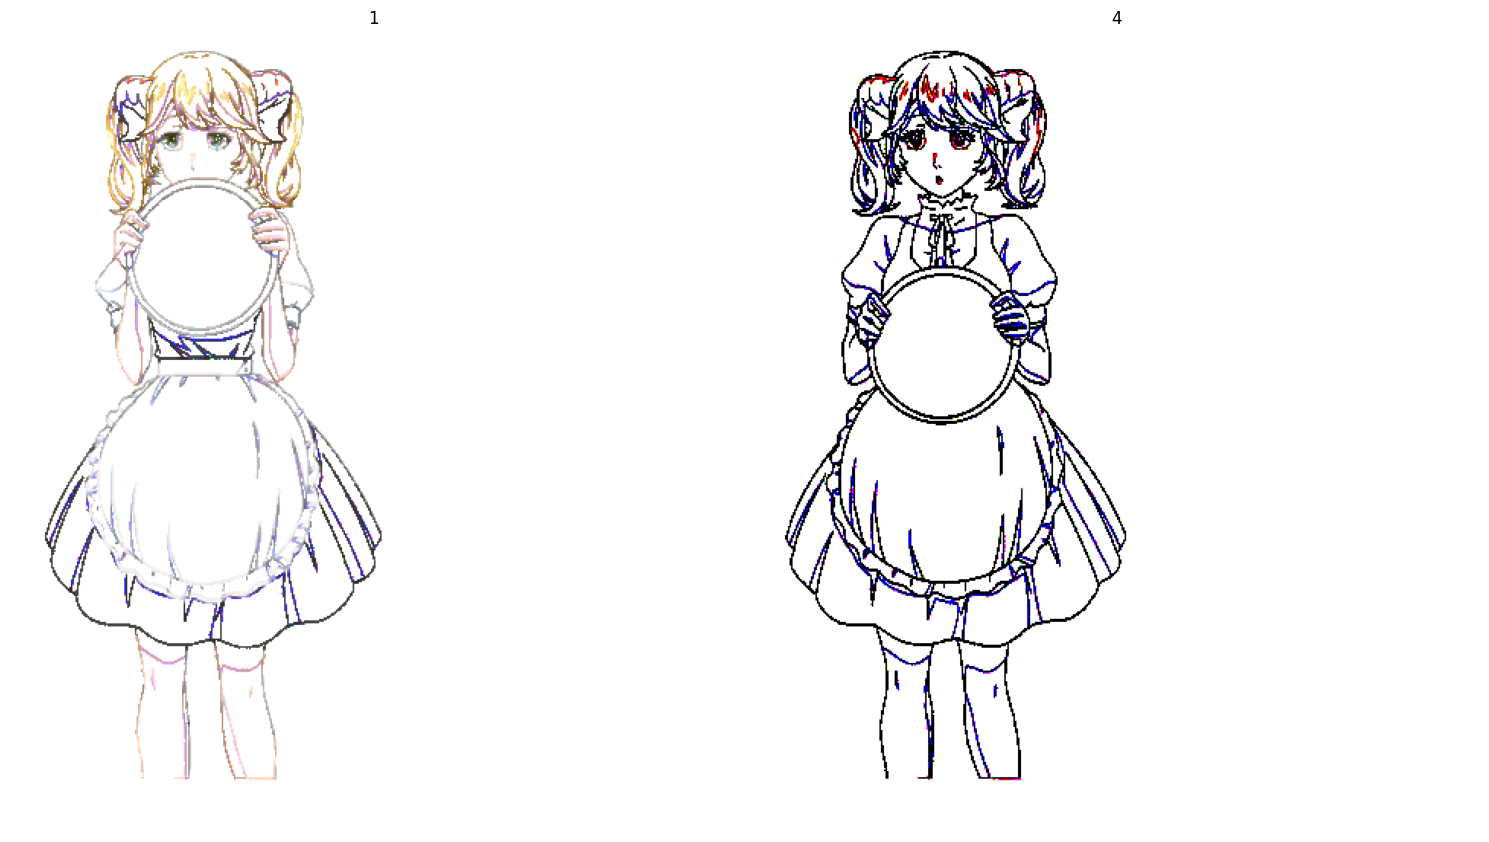

In [ ]:
# Read an image as a PyTorch tensor
images = [threshold(io.imread("dataset/sketch/sequence1/1.png"),220) +io.imread("dataset/colored/sequence1/1.png"), threshold(io.imread("dataset/sketch/sequence1/4.png"),220)]
imshow_plt( images, ['1', '4'])
print(images[0].shape)

#color first image 
classes_matrix , classes_num_list = assign_class_to_pixel_by_filling(images[0].copy())
image_colored = classes_matrix_to_image(classes_matrix, classes_num_list)
print('Apply pixel from previous to new')
#imshow_cv(image_colored)

#idee : essayer de faire de la reconnaissance de forme similaire entre duex image puis appliqué la classe  de l'image precedente sur les valeur des classe. 
# on peut essayer de comparé les homographie. on fait ca seulement sur les keypoints puis on rempli avec la couleur du du pixel correspondant.